### Описание датасета:

- `id` — идентификатор заявки. Заявки пронумерованы так, что большему номеру соответствует более поздняя дата заявки.
- `rn` — порядковый номер кредитного продукта в кредитной истории. Большему номеру соответствует продукт с более поздней датой открытия.
- `pre_since_opened` — количество дней с даты открытия кредита до даты сбора данных (бинаризовано*).
- `pre_since_confirmed` — количество дней с даты подтверждения информации по кредиту до даты сбора данных (бинаризовано*).
- `pre_pterm` — плановое количество дней с даты открытия кредита до даты закрытия (бинаризовано*).
- `pre_fterm` — фактическое количество дней с даты открытия кредита до даты закрытия (бинаризовано*).
- `pre_till_pclose` — плановое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*).
- `pre_till_fclose` — фактическое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*).
- `pre_loans_credit_limit` — кредитный лимит (бинаризовано*).
- `pre_loans_next_pay_summ` — сумма следующего платежа по кредиту (бинаризовано*).
- `pre_loans_outstanding` — оставшаяся невыплаченная сумма кредита (бинаризовано*).
- `pre_loans_total_overdue` — текущая просроченная задолженность (бинаризовано*).
- `pre_loans_max_overdue_sum` — максимальная просроченная задолженность (бинаризовано*).
- `pre_loans_credit_cost_rate` — полная стоимость кредита (бинаризовано*).
- `pre_loans5` — число просрочек до 5 дней (бинаризовано*).
- `pre_loans530` — число просрочек от 5 до 30 дней (бинаризовано*).
- `pre_loans3060` — число просрочек от 30 до 60 дней (бинаризовано*).
- `pre_loans6090` — число просрочек от 60 до 90 дней (бинаризовано*).
- `pre_loans90` — число просрочек более чем на 90 дней (бинаризовано*).
- `is_zero_loans_5` — флаг: нет просрочек до 5 дней.
- `is_zero_loans_530` — флаг: нет просрочек от 5 до 30 дней.
- `is_zero_loans_3060` — флаг: нет просрочек от 30 до 60 дней.
- `is_zero_loans_6090` — флаг: нет просрочек от 60 до 90 дней.
- `is_zero_loans90` — флаг: нет просрочек более чем на 90 дней.
- `pre_util` — отношение оставшейся невыплаченной суммы кредита к кредитному лимиту (бинаризовано*).
- `pre_over2limit` — отношение текущей просроченной задолженности к кредитному лимиту (бинаризовано*).
- `pre_maxover2limit` — отношение максимальной просроченной задолженности к кредитному лимиту (бинаризовано*).
- `is_zero_util` — флаг: отношение оставшейся невыплаченной суммы кредита к кредитному лимиту равно 0.
- `is_zero_over2limit` — флаг: отношение текущей просроченной задолженности к кредитному лимиту равно 0.
- `is_zero_maxover2limit` — флаг: отношение максимальной просроченной задолженности к кредитному лимиту равно 0.
- `enc_paym_{0..N}` — статусы ежемесячных платежей за последние N месяцев (закодировано**).
- `enc_loans_account_holder_type` — тип отношения к кредиту (закодировано**).
- `enc_loans_credit_status` — статус кредита (закодировано**).
- `enc_loans_account_cur` — валюта кредита (закодировано**).
- `enc_loans_credit_type` — тип кредита (закодировано**).
- `pclose_flag` — флаг: плановое количество дней с даты открытия кредита до даты закрытия не определено.
- `fclose_flag` — флаг: фактическое количество дней с даты открытия кредита до даты закрытия не определено.

### Import

In [ ]:
!pip install -q catboost

from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# Аутентификация и подключение Google Диска
drive.mount('/content/drive')
gauth = GoogleAuth()
drive = GoogleDrive(gauth)

import sys
sys.path.append('/content/drive/MyDrive/AI')

from data_processing import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00


###Load Data

In [ ]:
TRAIN_DATA_PATH = "/content/drive/MyDrive/AI/train_data.zip"

In [ ]:
def process_parquet_dataset_from_zip(zip_path: str, columns: List[str] = None, verbose: bool = False) -> pd.DataFrame:
    """
    Функция для обработки и объединения партиций данных в формате parquet из zip-архива.

    Параметры:
    - zip_path: путь к zip-архиву с parquet-файлами.
    - columns: список столбцов для загрузки. Если None, загружаются все столбцы.
    - verbose: если True, выводит информацию о ходе обработки.

    Возвращает:
    - result: объединенный DataFrame с данными из всех партиций.
    """

    # Извлечение файлов формата parquet из zip-архива
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/tmp')

    # Получение словаря с путями к файлам parquet, где ключ - номер партиции, значение - путь к файлу.
    dataset_paths = {int(os.path.splitext(filename)[0].split("_")[-1]): os.path.join('/tmp', 'train_data', filename)
                     for filename in os.listdir('/tmp/train_data') if filename.endswith('.pq')}

    # Сортировка путей к файлам по номеру партиции
    chunks = [dataset_paths[num] for num in sorted(dataset_paths.keys())]

    dataframes = []  # список для хранения загруженных данных

    # Если verbose=True, вывод информации о путях к файлам
    if verbose:
        print("Processing chunks:", *chunks, sep="\n")

    # Последовательное чтение и обработка каждого файла
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Processing dataset with pandas"):
        df = pd.read_parquet(chunk_path, columns=columns)
        df = reduce_mem_usage(df)  # уменьшение использования памяти
        dataframes.append(df)
        del df  # освобождение памяти перед загрузкой следующего файла

    # Объединение всех загруженных данных в один DataFrame
    result = pd.concat(dataframes, ignore_index=True)
    return result

In [ ]:
df = process_parquet_dataset_from_zip(TRAIN_DATA_PATH)

In [ ]:
# Assuming df is your DataFrame containing the 'id' column
# You can check if the 'id' column is in ascending order from 0 to the maximum value considering duplicates
is_id_in_ascending_order = df['id'].is_monotonic_increasing and df['id'].min() == 0 and df['id'].max() == df['id'].nunique() - 1

# Print the result
if is_id_in_ascending_order:
    print("The 'id' column is in ascending order from 0 to the maximum value (considering duplicates).")
else:
    print("The 'id' column is NOT in ascending order from 0 to the maximum value (considering duplicates).")

The 'id' column is in ascending order from 0 to the maximum value (considering duplicates).

### Data Cleaning


In [ ]:
def check_and_drop_columns(data, threshold=80, drop_columns=False):
    """
    Удаляет неинформативные столбцы и выводит процент популярного значения признака относительно всех его значений.

    Параметры:
    - data: DataFrame, исходные данные
    - threshold: int, пороговое значение в процентах для удаления столбцов (по умолчанию 80)
    - drop_columns: bool, указывает, нужно ли удалять столбцы (по умолчанию False)

    Возвращает:
    - DataFrame, обновленные данные после удаления столбцов, если drop_columns=True
    """

    # Create a copy of the original DataFrame to avoid modifying it
    data_new = data.copy()

    # Create a list of column names and their popular percentages
    columns_popular_percentage = [(column, (data_new[column].value_counts().max() / len(data_new[column])) * 100) for column in data_new.columns]

    # Sort columns by popular percentage in descending order
    columns_popular_percentage.sort(key=lambda x: x[1], reverse=True)

    # Iterate over columns to drop and print information
    for column, popular_percentage in columns_popular_percentage:
        clean_column_name = column.strip().encode('ascii', 'ignore').decode()
        if drop_columns and popular_percentage >= threshold and clean_column_name in data_new.columns:
            data_new.drop(clean_column_name, axis=1, inplace=True)
            print(f"Столбец '{clean_column_name}' удален ({popular_percentage:6.2f}%)")
        elif popular_percentage and not drop_columns:
            print(f"Столбец '{clean_column_name}' содержит популярное значение {popular_percentage:6.2f}%")

    if drop_columns:
        return data_new

In [ ]:
df = check_and_drop_columns(df, threshold=90, drop_columns=True)

Столбец 'pre_loans_total_overdue' удален (100.00%)
Столбец 'pre_loans6090' удален ( 99.99%)
Столбец 'pre_loans90' удален ( 99.94%)
Столбец 'pre_loans3060' удален ( 99.94%)
Столбец 'enc_loans_account_cur' удален ( 99.76%)
Столбец 'pre_loans5' удален ( 99.45%)
Столбец 'enc_loans_account_holder_type' удален ( 98.64%)
Столбец 'pre_loans530' удален ( 97.66%)
Столбец 'is_zero_loans90' удален ( 97.60%)
Столбец 'is_zero_loans6090' удален ( 97.54%)
Столбец 'is_zero_loans3060' удален ( 95.74%)
Столбец 'pre_over2limit' удален ( 93.28%)
Столбец 'is_zero_over2limit' удален ( 93.01%)
Столбец 'enc_paym_0' удален ( 92.25%)
Столбец 'pre_loans_max_overdue_sum' удален ( 92.01%)
Столбец 'is_zero_loans5' удален ( 91.87%)


In [ ]:
df = df.drop(['rn'], axis=1)

### Transform data

In [ ]:
def process_all_columns(df, path_to_output_dir):
    """
    Обрабатывает и сохраняет все столбцы DataFrame после OHE, кроме 'id'.

    Args:
    - df (DataFrame): исходные данные.
    - path_to_output_dir (str): путь к директории для сохранения.
    """

    # Убедимся, что директория для сохранения данных существует
    if not os.path.exists(path_to_output_dir):
        os.makedirs(path_to_output_dir)

    # Создание объекта OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    columns = df.columns

    # Создание индикатора прогресса
    with tqdm(total=len(columns) - 1, desc='Processing columns') as progress_bar:
        for column in columns:
            if column != 'id':
                # Применение OHE к столбцу
                data_ohe = ohe.fit_transform(df[[column]])
                ohe_columns = [f'{column}_{val}' for val in ohe.categories_[0]]
                df_ohe = pd.DataFrame(data_ohe, columns=ohe_columns)
                df_ohe['id'] = df['id'].values
                df_ohe = df_ohe.groupby('id').sum()

                # Сохранение df_ohe в файл
                output_file = os.path.join(path_to_output_dir, f"{column}_ohe.pkl")
                df_ohe.to_pickle(output_file)

                # Освобождение памяти
                del df_ohe
                gc.collect()

                progress_bar.update(1)

In [ ]:
# Пример использования функции
df = pd.read_joblib('/content/data_clean.joblib')  # Загрузка данных в DataFrame
path_to_output_dir = '/content/data_ohe'
process_all_columns(df, path_to_output_dir)

In [ ]:
def combine_ohe_files(path_to_output_dir, path_to_final_output):
    # Получение списка файлов в директории
    files = [os.path.join(path_to_output_dir, f) for f in os.listdir(path_to_output_dir) if f.endswith('.pkl')]

    # Загрузка и объединение всех файлов в один DataFrame
    dfs = []
    progress_bar = tqdm(total=len(files), desc='Combining files')
    for file in files:
        df = pd.read_pickle(file)
        dfs.append(df)
        progress_bar.update(1)
    progress_bar.close()

    df_combined = pd.concat(dfs, axis=1)

    # Сохранение итогового DataFrame
    df_combined.to_pickle(path_to_final_output)

# Использование функции
path_to_final_output = '/content/data_ohe_agg.pkl'
combine_ohe_files(path_to_output_dir, path_to_final_output)

Combining files: 100%|██████████| 43/43 [00:56<00:00,  1.32s/it]


In [ ]:
path_to_data_ohe_agg = '/content/drive/MyDrive/AI/data/data_ohe_agg.pkl'
path_to_train_target = '/content/drive/MyDrive/AI/data/train_target.csv'

In [ ]:
df = pd.read_pickle(path_to_data_ohe_agg)
train_target = pd.read_csv(path_to_train_target)

In [ ]:
reduce_mem_usage(df)
reduce_mem_usage(train_target)

Initial memory usage: 4577.64 MB
Final memory usage: 1161.58 MB
Reduced by 74.6%
Initial memory usage: 45.78 MB
Final memory usage: 14.31 MB
Reduced by 68.7%


In [ ]:
df = df.merge(train_target, on='id')

###Model

In [ ]:
X = df.drop(['id', 'flag'], axis=1)
y = df[['flag']]

In [ ]:
# 100k примеров для теста
X_remain, X_test, y_remain, y_test = train_test_split(
    X, y, test_size=100000, stratify=y, random_state=42
)

# разделим оставшиеся данные между тренировочным и валидационным наборами
X_train, X_valid, y_train, y_valid = train_test_split(
    X_remain, y_remain, test_size=0.2, stratify=y_remain, random_state=42
)

In [ ]:
# Параметры для обучения
params = {
    'num_leaves': 31,
    'objective': 'binary',
    'metric': 'auc',
    'n_estimators': 1000,
    'class_weight': 'balanced'
}

In [ ]:
model = LGBMClassifier(early_stopping_rounds=10, verbose=-1,**params)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

In [ ]:
preds_test = model.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, preds_test)
print(f"Test ROC-AUC Score: {roc_auc_test:.4f}")

Test ROC-AUC Score: 0.7579


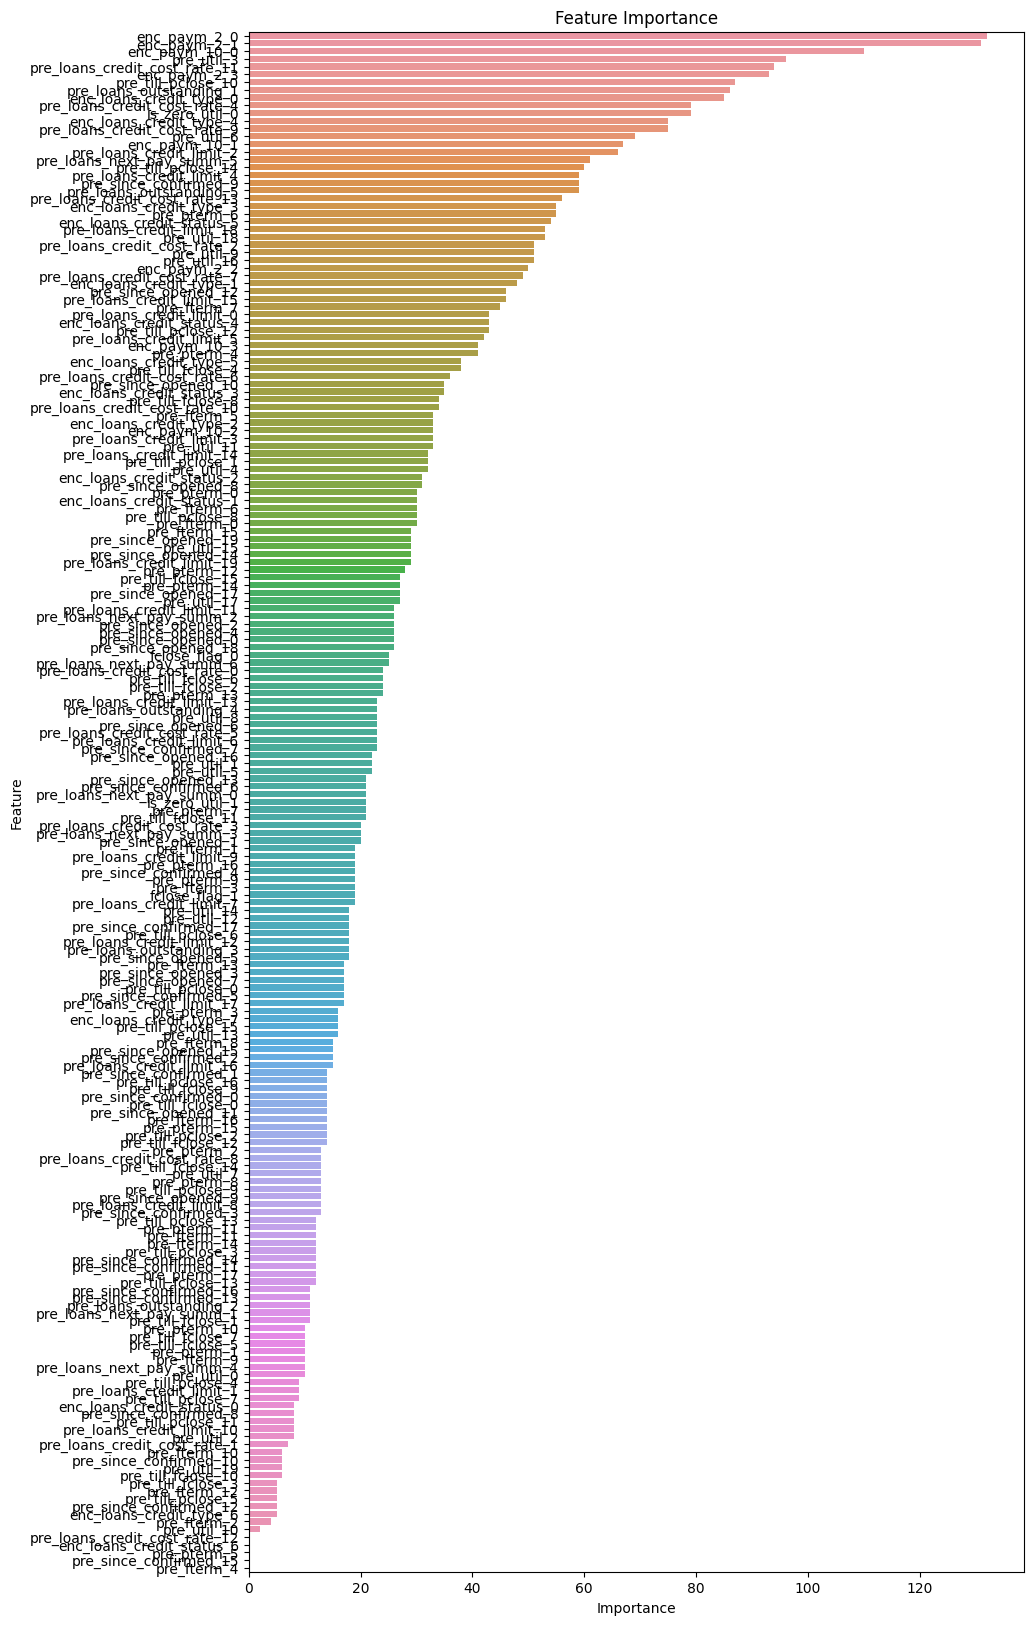

In [ ]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 20))
sns.barplot(data=feature_importances, y='Feature', x='Importance')
plt.title('Feature Importance')
plt.show()

In [ ]:
def plot_model(X_test, y_test, model=None, visualize=True):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Преобразование вероятностей в метки классов с порогом 0.5
    y_pred = np.where(y_pred_prob >= 0.5, 1, 0)

    print(f"\nROC AUC Score:\n{roc_auc:.4f}")
    df_classification_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

    if visualize:
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted class")
        plt.ylabel("True class")
        plt.show()

        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

    print("\nClassification Report:")
    display(df_classification_report)
    print(f"{'=='*40}\n")

    return roc_auc


ROC AUC Score:
0.7579


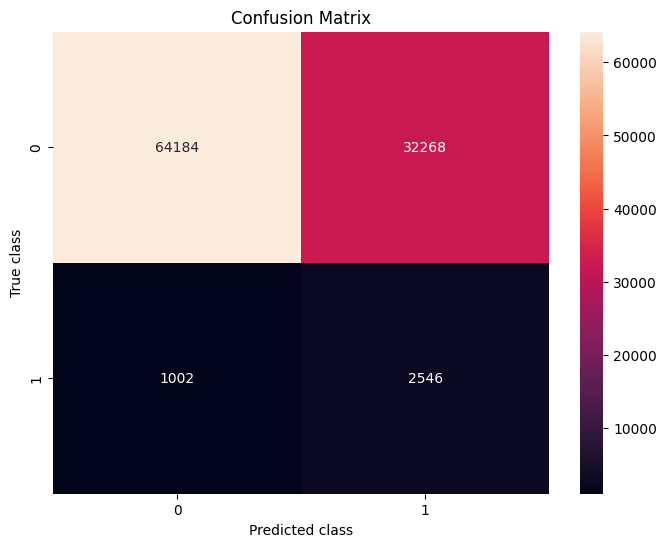

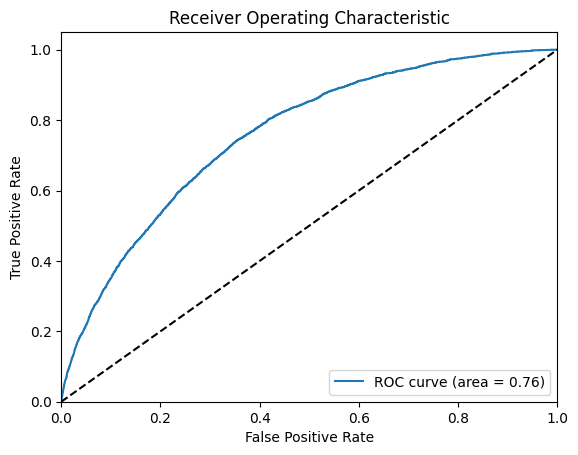


Classification Report:


,precision,recall,f1-score,support
0,0.984629,0.665450,0.794170,96452.0000
1,0.073131,0.717587,0.132736,3548.0000
accuracy,0.667300,0.667300,0.667300,0.6673
macro avg,0.528880,0.691519,0.463453,100000.0000
weighted avg,0.952289,0.667300,0.770702,100000.0000


0.7579028464883328

In [ ]:
plot_model(X_test, y_test, model=model)

In [ ]:
# Сохранить модель в файл
joblib.dump(model, 'lgb_model.joblib')

['lgb_model.joblib']

### Заключение:

Мы разработали модель для кредитного риск-менеджмента, которая продемонстрировала впечатляющие результаты:

1. **ROC-AUC 0.75**: Этот показатель говорит нам о высокой способности модели разделять рискованные и безопасные кредиты. Это ключевая метрика для нашей задачи.

2. **Полнота для класса 1 - 71.76%**: Несмотря на дисбаланс классов, модель успешно идентифицирует большую часть потенциально проблемных займов. Это важно для минимизации потерь.

3. **Точность 66.73%**: Модель в целом дает надежные прогнозы, что позволит нам принимать обоснованные решения по кредитам.

В завершение хочется сказать, что наша работа над этой задачей принесла свои плоды. Модель обладает всеми необходимыми качествами, чтобы стать надежным инструментом в арсенале кредитного отдела.